Ideal Output & Deliverables

The ideal output of this project will be:
A dashboard that implements predictive models to find what helps/harms a student's progression through school. 
A final report answers the Base Question:
What are the best predictors of student retention (i.e., the prevention of student dropouts)?

https://docs.google.com/document/d/1XHfDhUMD1c868baqg_8Kk4j2PJzwHRX8Psf7PTKLgss/edit?tab=t.0

In [2]:
import pandas as pd
import numpy as np

# Nigeria Data

### Loading in Data

In [5]:
df_Nigeria = pd.read_excel("/Users/matthewmaslow/Desktop//ds-save-the-children/Retention_Nigeria/Nigeria CuC Data - 2024 10 08.xlsx",
                                  sheet_name="_fact_student_attendance")
# supplementary dataset set only currently has literacy info, so not necessary to merge
df_Nigeria.head()

,GradeId,StudentIsPresent,ReasonType,StudentAbsenseReason,StudentAttendanceDate,ClassID,ChildrenId,SchoolId,AcademicYearId,AcademicYearName,Year,Project,Gender,RecordId,AcademicYearStartDate,AcademicYearEndtDate,SubjectId,SubjectName,Cycle
0,12,True,NaN,NaN,"Friday, August 18, 2023",421,8512,130,7.0,2023-CuC-Cycle1,2023.0,CuC,Female,27060,2023-07-10,2024-04-30,6,CuC,Cycle1
1,12,True,NaN,NaN,"Friday, August 18, 2023",421,2741,130,7.0,2023-CuC-Cycle1,2023.0,CuC,Male,27061,2023-07-10,2024-04-30,6,CuC,Cycle1
2,12,True,NaN,NaN,"Friday, August 18, 2023",421,2745,130,7.0,2023-CuC-Cycle1,2023.0,CuC,Male,27062,2023-07-10,2024-04-30,6,CuC,Cycle1
3,12,True,NaN,NaN,"Friday, August 18, 2023",421,2795,130,7.0,2023-CuC-Cycle1,2023.0,CuC,Male,27063,2023-07-10,2024-04-30,6,CuC,Cycle1
4,12,True,NaN,NaN,"Friday, August 18, 2023",421,8486,130,7.0,2023-CuC-Cycle1,2023.0,CuC,Female,27064,2023-07-10,2024-04-30,6,CuC,Cycle1


In [6]:
df_Nigeria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271773 entries, 0 to 271772
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   GradeId                271773 non-null  int64         
 1   StudentIsPresent       271773 non-null  bool          
 2   ReasonType             76182 non-null   object        
 3   StudentAbsenseReason   76182 non-null   object        
 4   StudentAttendanceDate  271773 non-null  object        
 5   ClassID                271773 non-null  int64         
 6   ChildrenId             271773 non-null  int64         
 7   SchoolId               271773 non-null  int64         
 8   AcademicYearId         228578 non-null  float64       
 9   AcademicYearName       228578 non-null  object        
 10  Year                   228578 non-null  float64       
 11  Project                228578 non-null  object        
 12  Gender                 271773 non-null  obje

### Data Prep

In [8]:
df_Nigeria['StudentIsPresent'] = df_Nigeria['StudentIsPresent'].astype(int)

df_Nigeria = df_Nigeria.drop(df_Nigeria.select_dtypes(include=['datetime64[ns]']).columns, axis=1)

df_Nigeria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271773 entries, 0 to 271772
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   GradeId                271773 non-null  int64  
 1   StudentIsPresent       271773 non-null  int64  
 2   ReasonType             76182 non-null   object 
 3   StudentAbsenseReason   76182 non-null   object 
 4   StudentAttendanceDate  271773 non-null  object 
 5   ClassID                271773 non-null  int64  
 6   ChildrenId             271773 non-null  int64  
 7   SchoolId               271773 non-null  int64  
 8   AcademicYearId         228578 non-null  float64
 9   AcademicYearName       228578 non-null  object 
 10  Year                   228578 non-null  float64
 11  Project                228578 non-null  object 
 12  Gender                 271773 non-null  object 
 13  RecordId               271773 non-null  int64  
 14  SubjectId              271773 non-nu

In [9]:
numeric_df_Nigeria = df_Nigeria.apply(pd.to_numeric, errors='coerce')
correlation_matrix = numeric_df_Nigeria.corr()

target_correlation = correlation_matrix['StudentIsPresent'].sort_values(ascending=False)
target_correlation


StudentIsPresent         1.000000
ClassID                  0.116642
AcademicYearId           0.097628
SchoolId                 0.073762
SubjectId                0.071102
RecordId                 0.069362
ChildrenId              -0.029176
GradeId                       NaN
ReasonType                    NaN
StudentAbsenseReason          NaN
StudentAttendanceDate         NaN
AcademicYearName              NaN
Year                          NaN
Project                       NaN
Gender                        NaN
SubjectName                   NaN
Cycle                         NaN
Name: StudentIsPresent, dtype: float64

In [10]:
# Mode imputation for categorical columns with missing values
for col in ['ReasonType', 'StudentAbsenseReason', 'Cycle']:
    df_Nigeria[col].fillna(df_Nigeria[col].mode()[0], inplace=True)

# Cramér's V calculation
categorical_columns = [
    "ReasonType", "StudentAbsenseReason", "StudentAttendanceDate", 
    "AcademicYearName", "Project", "Gender", "SubjectName", "Cycle"
]

import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Calculate Cramér's V for each categorical column against 'StudentIsPresent'
cramers_v_results = {col: cramers_v(df_Nigeria[col], df_Nigeria['StudentIsPresent']) for col in categorical_columns}
cramers_v_results


/var/folders/sf/c0xndf0951l35zqvq0zt2vy00000gn/T/ipykernel_89517/3933408201.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_Nigeria[col].fillna(df_Nigeria[col].mode()[0], inplace=True)
/var/folders/sf/c0xndf0951l35zqvq0zt2vy00000gn/T/ipykernel_89517/3933408201.py:19: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))


{'ReasonType': 0.00904443023229981,
 'StudentAbsenseReason': 0.00904443023229981,
 'StudentAttendanceDate': 0.14456375210989575,
 'AcademicYearName': 0.09761443311837062,
 'Project': 0.09761443311837062,
 'Gender': 0.021956522729096314,
 'SubjectName': 0.0760942302472515,
 'Cycle': nan}

### Model Training

In [12]:
df_Nigeria['StudentIsPresent'].value_counts()

StudentIsPresent
1    195591
0     76182
Name: count, dtype: int64

LogisticRegression....
Validation Accuracy: 0.88
Test Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60     15225
           1       0.85      0.80      0.83     39130

    accuracy                           0.76     54355
   macro avg       0.70      0.72      0.71     54355
weighted avg       0.77      0.76      0.76     54355



/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


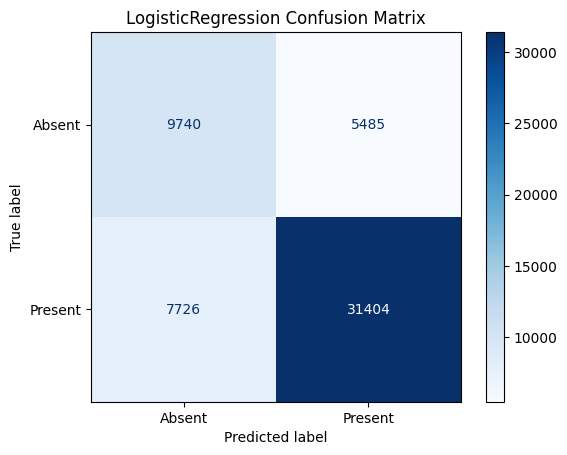

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForestClassifier....
Validation Accuracy: 0.72
Test Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.58      0.53     15225
           1       0.82      0.76      0.79     39130

    accuracy                           0.71     54355
   macro avg       0.65      0.67      0.66     54355
weighted avg       0.73      0.71      0.72     54355



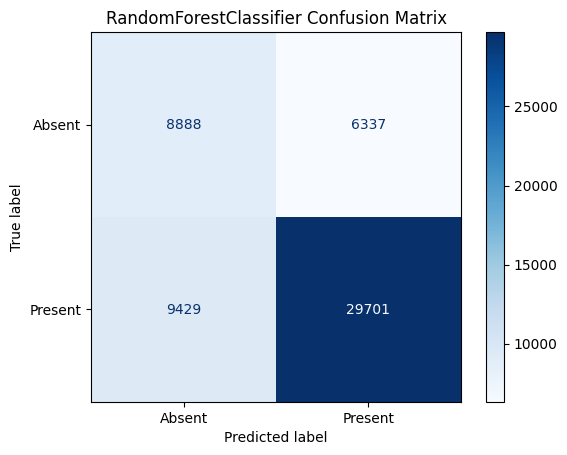



DecisionTreeClassifier....
Validation Accuracy: 0.74
Test Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.43      0.48     15225
           1       0.79      0.86      0.82     39130

    accuracy                           0.74     54355
   macro avg       0.66      0.64      0.65     54355
weighted avg       0.72      0.74      0.73     54355



/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


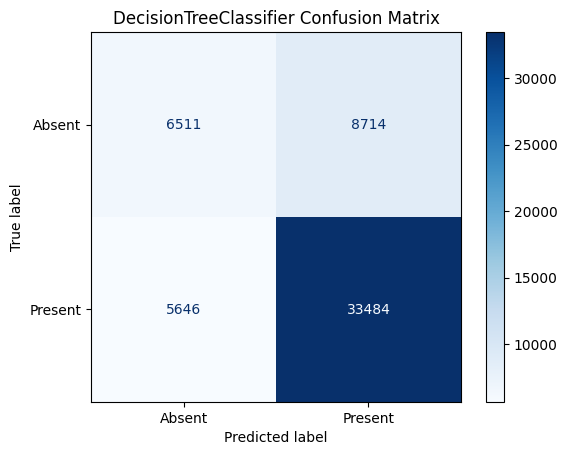

In [22]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

predictors = [
    "ClassID",
    "ChildrenId",
    "SchoolId",
    "AcademicYearId",
    "Project",
    "RecordId",
    "SubjectId",
    "Cycle"
]

df_Nigeria_pred = df_Nigeria[['StudentIsPresent'] + predictors]

transformer = make_column_transformer(
    (Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), predictors),
    remainder="passthrough"
)

X = df_Nigeria_pred.drop(columns=["StudentIsPresent"])
y = df_Nigeria_pred["StudentIsPresent"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
rf_model = RandomForestClassifier(
    random_state=0,
    class_weight='balanced',
    n_jobs=1,
    n_estimators=100,
    max_depth=25
)
dt_model = DecisionTreeClassifier(
    random_state=0,
    class_weight='balanced',
    max_depth=10,          
    min_samples_split=10,     
    min_samples_leaf=5        
)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = ImbPipeline([
        ('preprocessor', transformer),
        ('undersampler', RandomUnderSampler(sampling_strategy='not majority')),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{model.__class__.__name__}....")
    print(f"Validation Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    labels = ['Absent', 'Present']
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{model.__class__.__name__} Confusion Matrix")
    plt.show()

    print("\n" + "="*50 + "\n")
    
evaluate_model(logistic_model, X_train, X_test, y_train, y_test)
evaluate_model(rf_model, X_train, X_test, y_train, y_test)
evaluate_model(dt_model, X_train, X_test, y_train, y_test)

In [15]:
df_Nigeria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271773 entries, 0 to 271772
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   GradeId                271773 non-null  int64  
 1   StudentIsPresent       271773 non-null  int64  
 2   ReasonType             271773 non-null  object 
 3   StudentAbsenseReason   271773 non-null  object 
 4   StudentAttendanceDate  271773 non-null  object 
 5   ClassID                271773 non-null  int64  
 6   ChildrenId             271773 non-null  int64  
 7   SchoolId               271773 non-null  int64  
 8   AcademicYearId         228578 non-null  float64
 9   AcademicYearName       228578 non-null  object 
 10  Year                   228578 non-null  float64
 11  Project                228578 non-null  object 
 12  Gender                 271773 non-null  object 
 13  RecordId               271773 non-null  int64  
 14  SubjectId              271773 non-nu

In [16]:
df_Nigeria_1 = df_Nigeria[[
    "ClassID", "ChildrenId", "SchoolId", "StudentAttendanceDate", 
    "ReasonType", "AcademicYearName", "Gender", "Project", 
    "RecordId", "SubjectId", "Cycle", "StudentIsPresent"
]]

In [17]:
file_path = '/Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Nigeria/df_Nigeria_cleaned.xlsx'

df_Nigeria_1.to_excel(file_path, index=False)

print(f"File saved successfully at {file_path}")


File saved successfully at /Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Nigeria/df_Nigeria_cleaned.xlsx


In [18]:
file_path = '/Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Nigeria/df_Nigeria_cleaned.csv'

df_Nigeria_1.to_csv(file_path, index=False)

print(f"File saved successfully at {file_path}")


File saved successfully at /Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Nigeria/df_Nigeria_cleaned.csv


In [33]:
df_Nigeria_2 = pd.read_csv('/Users/matthewmaslow/Desktop/ds-save-the-children/Retention_Nigeria/df_Nigeria_cleaned.csv')
df_Nigeria_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271773 entries, 0 to 271772
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   ClassID                271773 non-null  int64 
 1   ChildrenId             271773 non-null  int64 
 2   SchoolId               271773 non-null  int64 
 3   StudentAttendanceDate  271773 non-null  object
 4   ReasonType             271773 non-null  object
 5   AcademicYearName       228578 non-null  object
 6   Gender                 271773 non-null  object
 7   Project                228578 non-null  object
 8   RecordId               271773 non-null  int64 
 9   SubjectId              271773 non-null  int64 
 10  Cycle                  271773 non-null  object
 11  StudentIsPresent       271773 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 24.9+ MB
